In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload

In [2]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)
nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


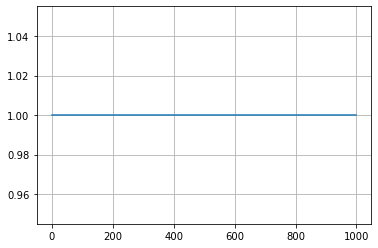

In [3]:
pix_size = 10 #arcmin
ell = np.arange(0, 1000)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:8: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))
/scratch/yuyang/destripe/lib.py:23: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Cl2d))


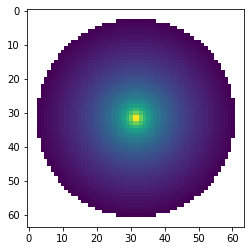

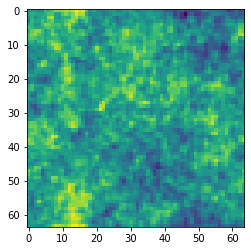

In [4]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
plt.imshow(m)

In [5]:
reload(lib)
M, M_c, D, D_inv, ell2d, ell2d_c = lib.generate_mask(m, pix_size, ell_cutoff = 300)

# A = D_inv @ M @ D
# A_c = D_inv @ M_c @ D

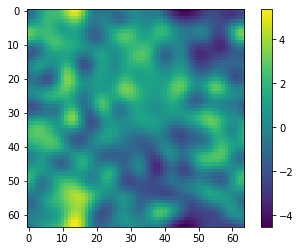

In [6]:
m_lf = D_inv @ M @ (D @ m.flatten())
plt.imshow(m_lf.reshape(nside, nside).real)
plt.colorbar()

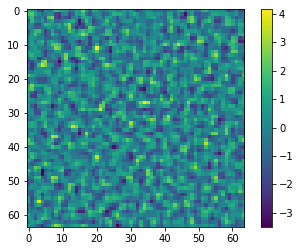

In [7]:
m_hf = D_inv @ M_c @ (D @ m.flatten())
plt.imshow(m_hf.reshape(nside, nside).real)
plt.colorbar()

In [8]:
recon_map = (m_hf + m_lf).reshape(nside, nside)

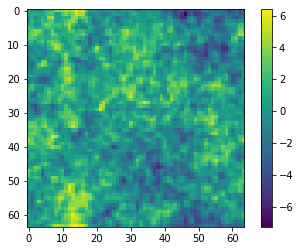

In [9]:
plt.imshow(recon_map.real)
plt.colorbar()

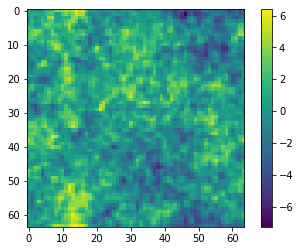

In [10]:
plt.imshow(m.real)
plt.colorbar()

In [11]:
np.max(np.abs(m - recon_map))
#good

7.862400937133893e-13

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


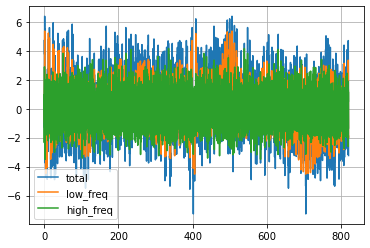

In [12]:
signal = P@m.flatten()
plt.plot(times, signal, label='total')
plt.plot(times, P @ m_lf, label='low_freq')
plt.plot(times, P @ m_hf, label='high_freq')
plt.legend()
plt.grid()

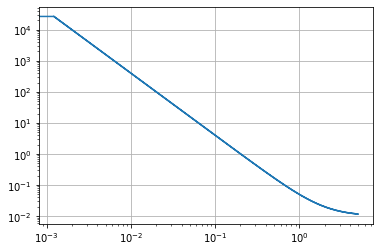

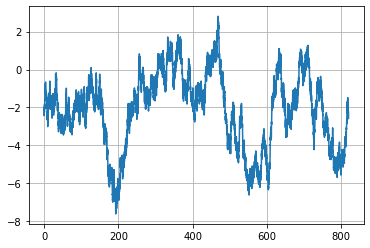

In [13]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=1e-1)
plt.plot(times, noise)
plt.grid()

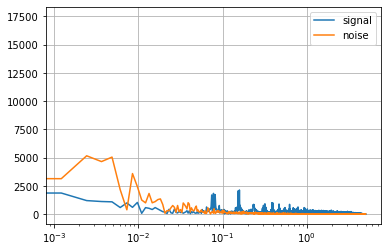

In [14]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.ylim([0, 1])
plt.grid()

In [15]:
y = signal + noise # + n

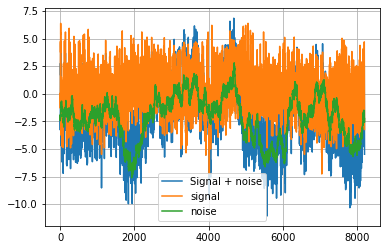

In [16]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [17]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = lib.generate_baselines(baseline_length, nsamp, rate)

In [18]:
#Fourier destriping
G = M.T @ D_inv.T @ P.T
Z = np.eye(nsamp) - P @ D_inv @ M @ np.linalg.inv(G @ P @ D_inv @ M) @ G

In [19]:
#Sx = b
A = F.T @ Z.T @ Z @ F 
b = F.T @ Z.T @ Z @ (y - P @ m_lf)

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

(82, 82) 82


In [33]:
import scipy.sparse.linalg as linalg

a, _ = linalg.cg(A, b)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


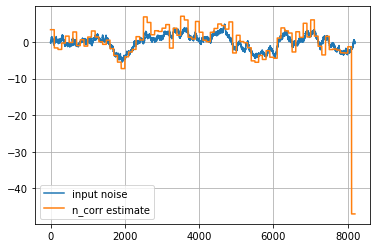

In [34]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [32]:
solver = np.linalg.inv(G @ P @ D_inv @ M) @ G
m_fourier = solver @ (y - P @ m_lf - F @ a) 

/tmp/ipykernel_21968/2766795741.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m_fourier = solver @ (y - P @ m_lf - F @ a)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 82)

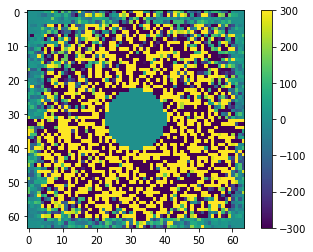

In [22]:
#Special handling of the fourier solution to set the low freq component to 0
m_fourier_hf = ell2d_c * m_fourier.reshape(nside, nside)
plt.imshow(np.fft.fftshift(m_fourier_hf).real, vmin=-300, vmax=300)
plt.colorbar();

In [30]:
m_destripe = D_inv @ m_fourier_hf.flatten()
m_destripe -= np.mean(m_destripe)

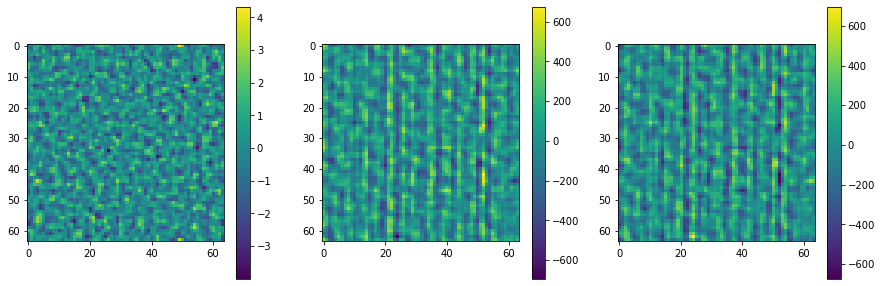

Input map std: 1.848073775989661
Solved map std: 264.2148706697062


In [32]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m_hf.reshape(nside, nside).real)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside).real)
diff_map = axes[2].imshow(m - m_destripe.reshape(nside, nside).real)

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m)}')
print(f'Solved map std: {np.std(m_destripe)}')